# Step 4 - Analysis of bicycle network results
## Project: Growing Urban Bicycle Networks with LTNs

This notebook takes the existing infrastructure, the results from 03_poi_based_generation and calculates/analyzes a number of measures:
* cost (length)
* coverage  
* directness  
* efficiency
* overlap with existing networks

Contact: Chris Larkin (c.larkin@ncl.ac.uk)  
Created: 2020-07-08  
Last modified: 2024-09-24

## Preliminaries

### Parameters

In [89]:
debug = True # If True, will produce plots and/or verbose output to double-check
rerun_existing = True # If True, will re-run the costly analysis of existing infra even if files already exist.
%run -i "../parameters/parameters.py"

Loaded parameters.



### Setup

In [90]:
%run -i path.py
%run -i setup.py
if not debug: # Only do this if sure the code is bug-free!
    warnings.filterwarnings('ignore')

%load_ext watermark
%watermark -n -v -m -g -iv

Loaded PATH.



=== Cities ===
{   'newcastle': {   'countryid': 'gbr',
                     'name': 'Newcastle upon Tyne',
                     'nominatimstring': 'Newcastle upon Tyne'}}


Setup finished.

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.12.6
IPython version      : 8.29.0

Compiler    : MSC v.1941 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores   : 8
Architecture: 64bit

Git hash: e97a0b3b6bf68d9b6e57120a8d794fc7ff24e404

sys       : 3.12.6 | packaged by conda-forge | (main, Sep 22 2024, 14:01:26) [MSC v.1941 64 bit (AMD64)]
pyproj    : 3.7.0
osgeo     : 3.9.3
geojson   : 3.1.0
pandas    : 2.2.3
momepy    : 0.8.1
tqdm      : 4.66.5
shapely   : 2.0.6
json      : 2.0.9
owslib    : 0.32.0
watermark : 2.5.0
igraph    : 0.11.6
dill      : 0.3.9
networkx  : 3.3
geopandas : 0.14.4
cs

### Functions

In [91]:
%run -i functions.py

Loaded functions.



### Network weighting by tags

In [92]:
%run -i tag_lts.py
%run -i distance_cost.py

## Load Results

In [93]:
# betweeness
filename = PATH["results"] + placeid + "/" + f"{placeid}_poi_{poi_source}_{prune_measure}_weighted.pickle"  

if os.path.exists(filename):
    with open(filename, "rb") as f:
        results = pickle.load(f)
else:
    print(f"File {filename} does not exist.")

In [94]:
# random
filename = PATH["results"] + placeid + "/" + f"{placeid}_poi_{poi_source}_random_weighted.pickle"  

if os.path.exists(filename):
    with open(filename, "rb") as f:
        results_random = pickle.load(f)
else:
    print(f"File {filename} does not exist.")

In [95]:
# # how to access....
# investment_levels = results["prune_quantiles"]
# GTs = results["GTs"]
# GT_abstracts = results["GT_abstracts"]

# # For example, convert the first graph in GTs to GeoDataFrames
# import osmnx as ox
# nodes, edges = ox.graph_to_gdfs(GTs[0])


Find investment level, split results into GTs, GT_abstracts 

In [96]:
investment_levels = results["prune_quantiles"]
investment_levels_random = results_random["prune_quantiles"]
GTs = results["GTs"]
GT_abstracts = results["GT_abstracts"]

if results_random:
    GTs_random = results_random["GTs"]
    GT_abstracts_random = results_random["GT_abstracts"]

#### Load other networks



In [97]:
# get biketrack graph
gpkg_path = PATH["data"] + placeid + "/" + placeid + '_biketrack.gpkg'
G_biketrack = ox_gpkg_to_graph(gpkg_path)
G_biketrack.remove_nodes_from(list(nx.isolates(G_biketrack)))


# get biketrack graph without LTNs
gpkg_path = PATH["data"] + placeid + "/" + placeid + '_biketrack_no_ltn.gpkg'
G_biketrack_no_ltn = ox_gpkg_to_graph(gpkg_path)
G_biketrack_no_ltn.remove_nodes_from(list(nx.isolates(G_biketrack)))

In [98]:
# setup

def csv_to_ox(p, placeid, parameterid):
    '''
    Load graph from csv files (nodes and edge)
    Include OSMID, length, highway, x, y attributes
    '''

    prefix = placeid + '_' + parameterid
    compress = check_extract_zip(p, prefix)
    
    with open(p + prefix + '_edges.csv', 'r') as f:
        header = f.readline().strip().split(",")
        lines = []
        for line in csv.reader(f, quotechar='"', delimiter=',', quoting=csv.QUOTE_ALL, skipinitialspace=True):
            line_list = [c for c in line]
            osmid = str(eval(line_list[header.index("osmid")])[0]) if isinstance(eval(line_list[header.index("osmid")]), list) else line_list[header.index("osmid")]
            length = str(eval(line_list[header.index("length")])[0]) if isinstance(eval(line_list[header.index("length")]), list) else line_list[header.index("length")]
            highway = line_list[header.index("highway")]
            if highway.startswith("[") and highway.endswith("]"):
                highway = highway.strip("[]").split(",")[0].strip(" '")
            line_string = f"{line_list[header.index('u')]} {line_list[header.index('v')]} {osmid} {length} {highway}"
            lines.append(line_string)
        G = nx.parse_edgelist(lines, nodetype=int, data=(("osmid", int), ("length", float), ("highway", str)), create_using=nx.MultiDiGraph)
    
    with open(p + prefix + '_nodes.csv', 'r') as f:
        header = f.readline().strip().split(",")
        values_x = {}
        values_y = {}
        for line in csv.reader(f, quotechar='"', delimiter=',', quoting=csv.QUOTE_ALL, skipinitialspace=True):
            line_list = [c for c in line]
            osmid = int(line_list[header.index("osmid")])
            values_x[osmid] = float(line_list[header.index("x")])
            values_y[osmid] = float(line_list[header.index("y")])
        nx.set_node_attributes(G, values_x, "x")
        nx.set_node_attributes(G, values_y, "y")
    
    if compress:
        os.remove(p + prefix + '_nodes.csv')
        os.remove(p + prefix + '_edges.csv')
    return G



# Analyse

Length - finding the distance of the connected network, along with the investment distance (length - existing infrastructure)

In [99]:
# # Get the first 5 edges
# edges = list(G.edges(data=True))[:5]

# # Print the edge attributes
# for edge in edges:
#     print(edge)

#### Pure length - how is the budget used per iteration

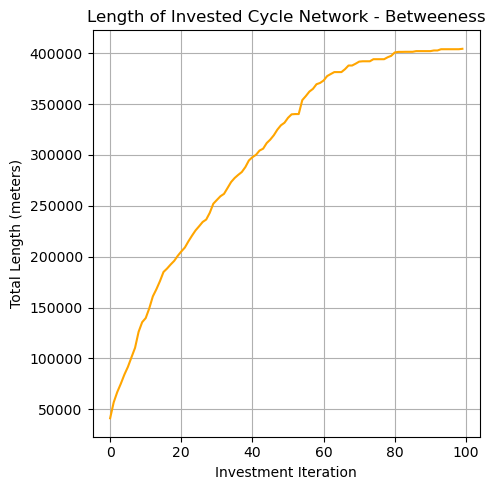

In [100]:
total_lengths = []
for G in GTs:
    # Use nx.get_edge_attributes to retrieve the edge lengths
    lengths = nx.get_edge_attributes(G, 'length')  # Returns a dictionary {edge: length}
    total_length = sum(lengths.values())  # Sum up the lengths
    total_lengths.append(total_length)

# Plot the total lengths
plt.figure(figsize=(5, 5))  # Narrower and taller dimensions
plt.plot(total_lengths, linestyle='-', color='orange')
plt.xlabel('Investment Iteration')
plt.ylabel('Total Length (meters)')
plt.title('Length of Invested Cycle Network - Betweeness')
plt.grid(True)
plt.tight_layout()  # Adjust spacing for a clean look
plt.show()

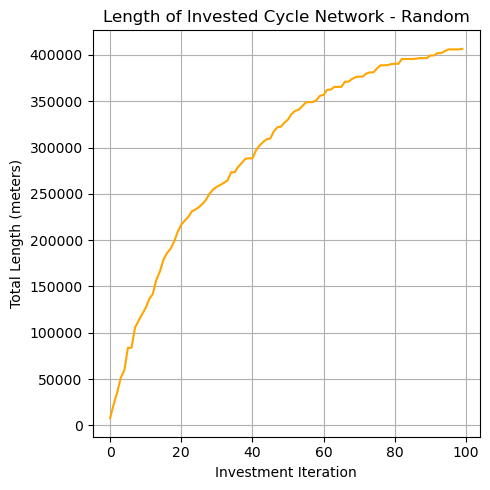

In [101]:
total_lengths = []
for G in GTs_random:
    # Use nx.get_edge_attributes to retrieve the edge lengths
    lengths = nx.get_edge_attributes(G, 'length')  # Returns a dictionary {edge: length}
    total_length = sum(lengths.values())  # Sum up the lengths
    total_lengths.append(total_length)

# Plot the total lengths
plt.figure(figsize=(5, 5))  # Narrower and taller dimensions
plt.plot(total_lengths, linestyle='-', color='orange')
plt.xlabel('Investment Iteration')
plt.ylabel('Total Length (meters)')
plt.title('Length of Invested Cycle Network - Random')
plt.grid(True)
plt.tight_layout()  # Adjust spacing for a clean look
plt.show()

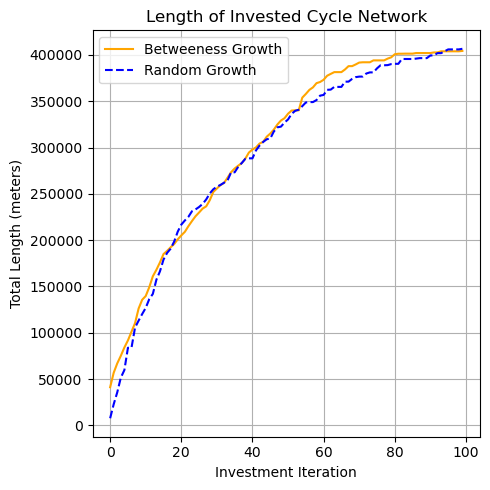

In [102]:

total_lengths = []
for G in GTs:
    lengths = nx.get_edge_attributes(G, 'length')
    total_length = sum(lengths.values())
    total_lengths.append(total_length)

plt.figure(figsize=(5, 5))
plt.plot(total_lengths, linestyle='-', color='orange', label='Betweeness Growth')

# Plot the total lengths for Random_GTs
random_total_lengths = []
for G in GTs_random:
    lengths = nx.get_edge_attributes(G, 'length')
    total_length = sum(lengths.values())
    random_total_lengths.append(total_length)

plt.plot(random_total_lengths, linestyle='--', color='blue', label='Random Growth')

plt.xlabel('Investment Iteration')
plt.ylabel('Total Length (meters)')
plt.title('Length of Invested Cycle Network')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### "Actual" investment length - how much do we actually need to use to close gaps

Calculate length, minus the existing infrastructure

In [105]:
for G in GTs:
    for u, v, data in G.edges(data=True):
        highway_type = data.get('highway', 'unclassified') # Default to unclassified if no highway attribute
        length = data.get('length', 0) # Default to 0 if no length attribute
        investment_length = length * distance_cost.get(highway_type, 1) 
        data['investment_length'] = investment_length # make a new edge attribute called investment_length

if GTs_random:
    for G in GTs_random:
        for u, v, data in G.edges(data=True):
            highway_type = data.get('highway', 'unclassified')
            length = data.get('length', 0)
            investment_length = length * distance_cost.get(highway_type, 1)
            data['investment_length'] = investment_length



#### Find how much we actually need to invest

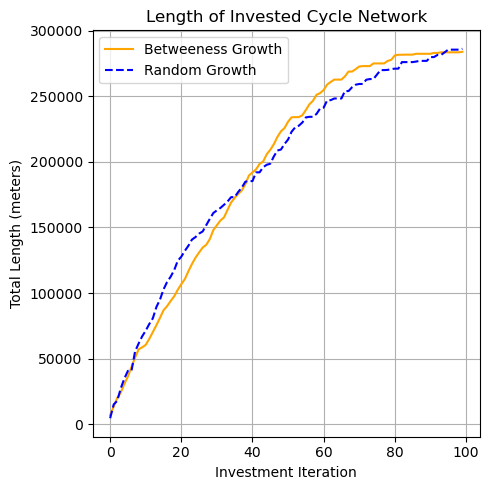

In [ ]:

total_lengths = []
for G in GTs:
    lengths = nx.get_edge_attributes(G, 'investment_length')
    total_length = sum(lengths.values())
    total_lengths.append(total_length)

plt.figure(figsize=(5, 5))
plt.plot(total_lengths, linestyle='-', color='orange', label='Betweeness Growth')

# Plot the total lengths for Random_GTs
random_total_lengths = []
for G in GTs_random:
    lengths = nx.get_edge_attributes(G, 'investment_length')
    total_length = sum(lengths.values())
    random_total_lengths.append(total_length)

plt.plot(random_total_lengths, linestyle='--', color='blue', label='Random Growth')

plt.xlabel('Investment Iteration')
plt.ylabel('Total Length (meters)')
plt.title('Length of Investment needed')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Find comparison between how much we need against full route lengths

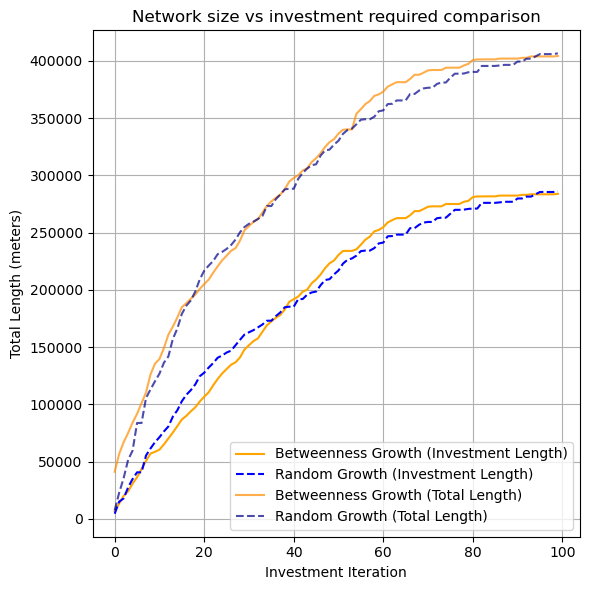

In [108]:
# Compute total lengths using 'investment_length'
investment_total_lengths = [sum(nx.get_edge_attributes(G, 'investment_length').values()) for G in GTs]
random_investment_total_lengths = [sum(nx.get_edge_attributes(G, 'investment_length').values()) for G in GTs_random]

# Compute total lengths using 'length'
length_total_lengths = [sum(nx.get_edge_attributes(G, 'length').values()) for G in GTs]
random_length_total_lengths = [sum(nx.get_edge_attributes(G, 'length').values()) for G in GTs_random]

# Plot both sets of lines
plt.figure(figsize=(6, 6))

# Original lines
plt.plot(investment_total_lengths, linestyle='-', color='orange', label='Betweenness Growth (Investment Length)')
plt.plot(random_investment_total_lengths, linestyle='--', color='blue', label='Random Growth (Investment Length)')

# Darker lines for 'length' attribute
plt.plot(length_total_lengths, linestyle='-', color='darkorange', alpha=0.7, label='Betweenness Growth (Total Length)')
plt.plot(random_length_total_lengths, linestyle='--', color='darkblue', alpha=0.7, label='Random Growth (Total Length)')

plt.xlabel('Investment Iteration')
plt.ylabel('Total Length (meters)')
plt.title('Network size vs investment required comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Find differance between network size and required investment

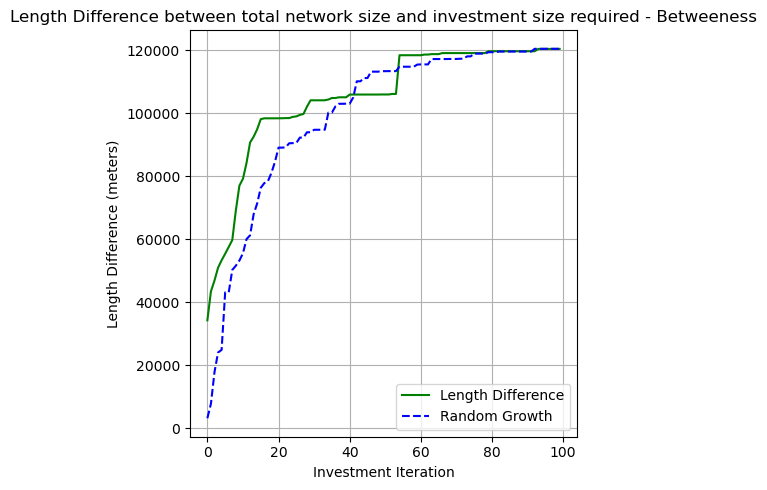

In [ ]:
length_differences = []
for G in GTs:
    lengths = nx.get_edge_attributes(G, 'length')
    investment_lengths = nx.get_edge_attributes(G, 'investment_length')
    total_length = sum(lengths.values())
    total_investment_length = sum(investment_lengths.values())
    length_difference = total_length - total_investment_length
    length_differences.append(length_difference)

random_length_differences = []
for G in GTs_random:
    random_lengths = nx.get_edge_attributes(G, 'length')
    random_investment_lengths = nx.get_edge_attributes(G, 'investment_length')
    random_total_length = sum(random_lengths.values())
    random_total_investment_length = sum(random_investment_lengths.values())
    random_length_difference = random_total_length - random_total_investment_length
    random_length_differences.append(random_length_difference)




# Plot the length differences
plt.figure(figsize=(5, 5))
plt.plot(length_differences, linestyle='-', color='green', label='Length Difference')
plt.plot(random_length_differences, linestyle='--', color='blue', label='Random Growth')
plt.xlabel('Investment Iteration')
plt.ylabel('Length Difference (meters)')
plt.title('Length Difference between total network size and investment size required')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

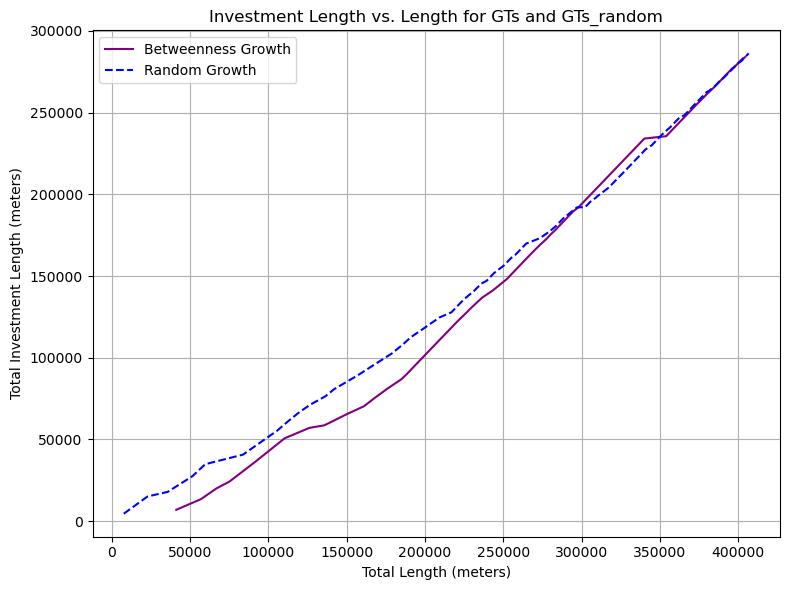

In [115]:
lengths_list = []
investment_lengths_list = []

random_lengths_list = []
random_investment_lengths_list = []

# Process GTs
for G in GTs:
    lengths = nx.get_edge_attributes(G, 'length')
    investment_lengths = nx.get_edge_attributes(G, 'investment_length')
    
    total_length = sum(lengths.values())
    total_investment_length = sum(investment_lengths.values())
    
    lengths_list.append(total_length)
    investment_lengths_list.append(total_investment_length)

# Process GTs_random
for G in GTs_random:
    lengths = nx.get_edge_attributes(G, 'length')
    investment_lengths = nx.get_edge_attributes(G, 'investment_length')
    
    total_length = sum(lengths.values())
    total_investment_length = sum(investment_lengths.values())
    
    random_lengths_list.append(total_length)
    random_investment_lengths_list.append(total_investment_length)

# Plot the lengths against investment lengths
plt.figure(figsize=(8, 6))
plt.plot(lengths_list, investment_lengths_list, '-', color='purple', label='Betweenness Growth')
plt.plot(random_lengths_list, random_investment_lengths_list, '--', color='blue', label='Random Growth')
plt.xlabel('Total Length (meters)')
plt.ylabel('Total Investment Length (meters)')
plt.title('Investment Length vs. Length for GTs and GTs_random')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Distance gained

Here we are trying to find how much of the existing network is connected per iteration. 

total bike network - G_bikeall

G'investment_length' - investment size

G'length' - length of created network, not including netowrk size

need to do a compose of G_bikeall and G in GTs

but only compose where infrastucutre is connected to our generated network 

In [139]:
sum(data.get('length', 1) for u, v, data in G_biketrack.edges(data=True))

185476.667

In [134]:
def total_length(G):
    return sum(data.get('length', 1) for _, _, data in G.edges(data=True))

for i, G in enumerate(GTs):
    length_before = total_length(G)
    G_composed = nx.compose(G, G_biketrack)
    length_after = total_length(G_composed)
    
    print(f"Graph {i+1}:")
    print(f"  Total length before composition: {length_before}")
    print(f"  Total length after composition: {length_after}")
    print("-" * 40)


Graph 1:
  Total length before composition: 41204.125
  Total length after composition: 209473.957
----------------------------------------
Graph 2:
  Total length before composition: 56852.523
  Total length after composition: 220524.891
----------------------------------------
Graph 3:
  Total length before composition: 66963.372
  Total length after composition: 228841.721
----------------------------------------
Graph 4:
  Total length before composition: 75134.208
  Total length after composition: 234981.837
----------------------------------------
Graph 5:
  Total length before composition: 84104.352
  Total length after composition: 242573.938
----------------------------------------
Graph 6:
  Total length before composition: 91767.656
  Total length after composition: 249150.844
----------------------------------------
Graph 7:
  Total length before composition: 101160.783
  Total length after composition: 257447.339
----------------------------------------
Graph 8:
  Total le

KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__del__'
Traceback (most recent call last):
  File "_zmq.py", line 160, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 


Graph 11:
  Total length before composition: 139699.848
  Total length after composition: 284061.657
----------------------------------------
Graph 12:
  Total length before composition: 149296.432
  Total length after composition: 291164.795
----------------------------------------
Graph 13:
  Total length before composition: 160999.401
  Total length after composition: 299610.031
----------------------------------------
Graph 14:
  Total length before composition: 168037.987
  Total length after composition: 305727.058
----------------------------------------
Graph 15:
  Total length before composition: 175986.752
  Total length after composition: 312488.93
----------------------------------------
Graph 16:
  Total length before composition: 185004.033
  Total length after composition: 319908.536
----------------------------------------
Graph 17:
  Total length before composition: 188395.551
  Total length after composition: 323165.174
----------------------------------------
Graph 1

Find the length of infrastructure connected to generated network, along with the combined length

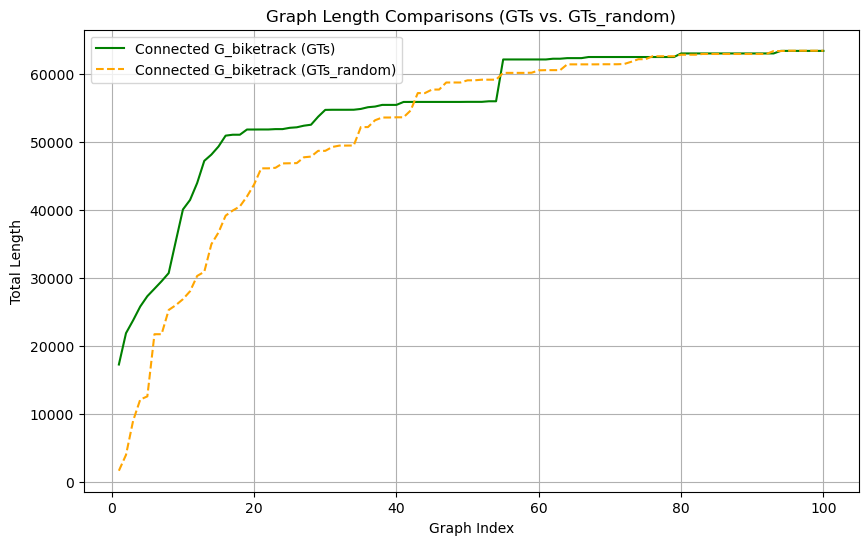

In [144]:
import networkx as nx
import matplotlib.pyplot as plt

def total_length(G):
    """Computes total edge length in a graph."""
    return sum(data.get('length', 1) for _, _, data in G.edges(data=True))

def compute_lengths(graph_list, G_biketrack):
    """Computes total, connected, and combined lengths for a list of graphs."""
    G_lengths = []
    biketrack_lengths = []
    combined_lengths = []

    for G in graph_list:
        length_G = total_length(G)

        # Find overlapping nodes
        common_nodes = set(G.nodes) & set(G_biketrack.nodes)

        # Extract the connected subgraph of G_biketrack
        G_biketrack_subgraph = G_biketrack.subgraph(common_nodes)
        length_G_biketrack_connected = total_length(G_biketrack_subgraph)

        # Compute final combined length
        total_combined_length = length_G + length_G_biketrack_connected

        # Store values for plotting
        G_lengths.append(length_G)
        biketrack_lengths.append(length_G_biketrack_connected)
        combined_lengths.append(total_combined_length)

    return G_lengths, biketrack_lengths, combined_lengths

# Compute lengths for both GTs and GTs_random
G_lengths, biketrack_lengths, combined_lengths = compute_lengths(GTs, G_biketrack)
G_random_lengths, biketrack_random_lengths, combined_random_lengths = compute_lengths(GTs_random, G_biketrack)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot GTs
#plt.plot(range(1, len(GTs) + 1), G_lengths, marker='o', linestyle='-', color='blue', label="G (GTs)")
plt.plot(range(1, len(GTs) + 1), biketrack_lengths,  linestyle='-', color='green', label="Connected G_biketrack (GTs)")
#plt.plot(range(1, len(GTs) + 1), combined_lengths, marker='^', linestyle='-', color='purple', label="Combined Total (GTs)")

# Plot GTs_random
#plt.plot(range(1, len(GTs_random) + 1), G_random_lengths, marker='o', linestyle='--', color='red', label="G (GTs_random)")
plt.plot(range(1, len(GTs_random) + 1), biketrack_random_lengths,  linestyle='--', color='orange', label="Connected G_biketrack (GTs_random)")
#plt.plot(range(1, len(GTs_random) + 1), combined_random_lengths, marker='^', linestyle='--', color='brown', label="Combined Total (GTs_random)")

# Labels and title
plt.xlabel("Graph Index")
plt.ylabel("Total Length")
plt.title("Graph Length Comparisons (GTs vs. GTs_random)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
GTs_random

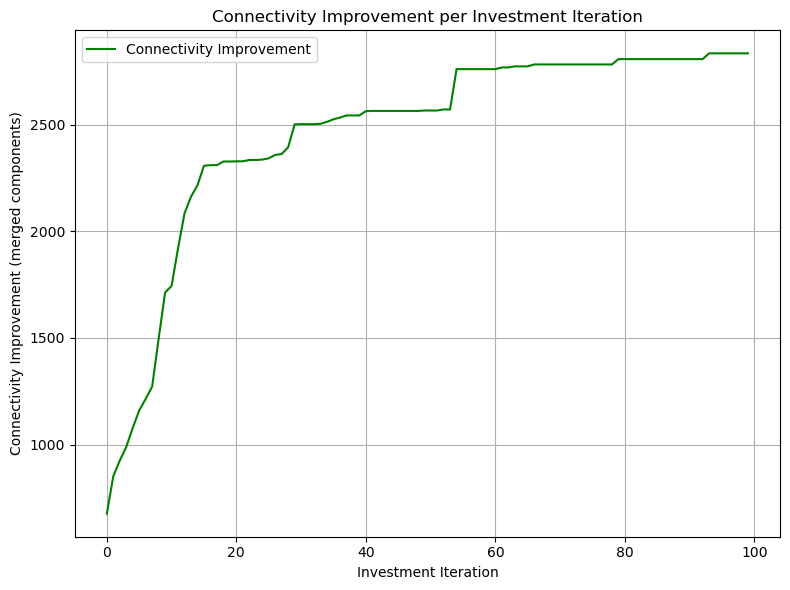

In [125]:
len_improvements = [len_imp for _, _, len_imp in results]

# Plot the connectivity improvements
plt.figure(figsize=(8, 6))
plt.plot(len_improvements, linestyle='-', color='green', label='Connectivity Improvement')
plt.xlabel('Investment Iteration')
plt.ylabel('Connectivity Improvement (merged components)')
plt.title('Connectivity Improvement per Investment Iteration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

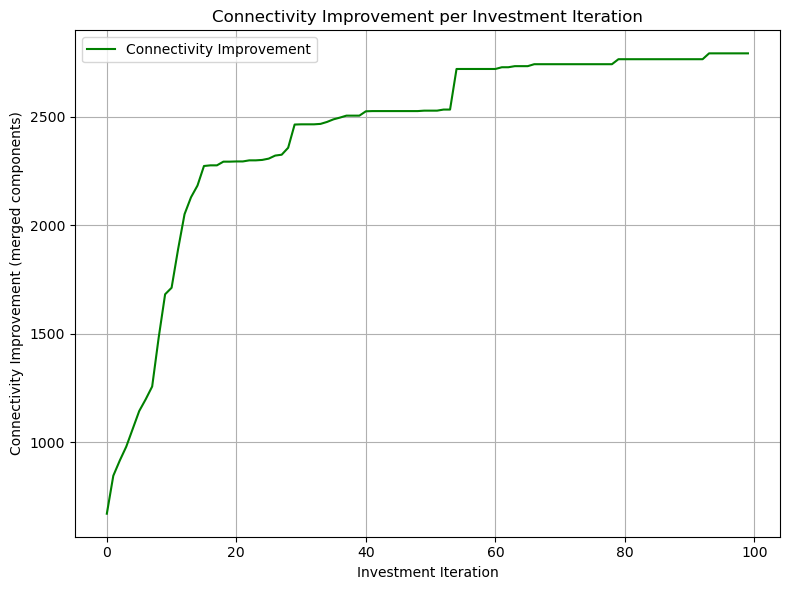

In [ ]:
conn_improvements = [conn_imp for _, conn_imp, _ in results]

# Plot the connectivity improvements
plt.figure(figsize=(8, 6))
plt.plot(conn_improvements, linestyle='-', color='green', label='Connectivity Improvement')
plt.xlabel('Investment Iteration')
plt.ylabel('Connectivity Improvement (merged components)')
plt.title('Connectivity Improvement per Investment Iteration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:

last_graph = GTs[-1]

# Calculate the total length of the network
total_length = sum(data['length'] for u, v, data in last_graph.edges(data=True))

total_length


301288.8

In [51]:

import networkx as nx

# Get the last item in the list GTs
last_graph = GTs_random[-1]

# Calculate the total length of the network
total_length = sum(data['length'] for u, v, data in last_graph.edges(data=True))

total_length


63479.789

Coverage

In [52]:
Audio(sound_file, autoplay=True) 